# Телеком — прогноз оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

**Также доступны такие услуги:**

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Описание полей данных

- `BeginDate` - дата начала пользования услугами;
- `EndDate` - дата окончания пользования услугами;
- `Type` - тип оплаты: ежемесячный, годовой и т.д.;
- `PaperlessBilling` - электронный платежный документ;
- `PaymentMethod` - способ оплаты;
- `MonthlyCharges` - ежемесячные траты на услуги;
- `TotalCharges` - всего потрачено денег на услуги;
- `Dependents` - наличие иждевенцев;
- `Senior Citizen` - наличие пенсионного статуса по возрасту;
- `Partner` - наличие супруга(и);
- `MultipleLines` - наличе возможности ведения параллельных линий во время звонка.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
from catboost import *
from phik import report
from phik.report import plot_correlation_matrix
from skimpy import clean_columns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 270323
path_local = 'D:/Yandex_Practikum/Dataset/final_provider/'
path = '/datasets/final_provider/'

In [3]:
time_limit = pd.Timestamp(2020, 2, 1)

# Загрузка данных

In [4]:
# общий путь
try:
    df_contract = pd.read_csv(path + 'contract.csv', index_col=[0], parse_dates=[1,2])
    df_internet = pd.read_csv(path + 'internet.csv', index_col=[0])
    df_personal = pd.read_csv(path + 'personal.csv', index_col=[0])
    df_phone = pd.read_csv(path + 'phone.csv', index_col=[0])
# локальный путь    
except:
    df_contract = pd.read_csv(path_local + 'contract.csv', index_col=[0], parse_dates=[1,2])
    df_internet = pd.read_csv(path_local + 'internet.csv', index_col=[0])
    df_personal = pd.read_csv(path_local + 'personal.csv', index_col=[0])
    df_phone = pd.read_csv(path_local + 'phone.csv', index_col=[0])

tables = {'contract': df_contract, 'personal': df_personal, 'internet': df_internet, 'phone': df_phone}

## Изучение данных

In [5]:
for table in tables.values():
    display(table.head(3))

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No


In [6]:
for table in tables:
    print(table, tables[table].shape)

contract (7043, 7)
personal (7043, 4)
internet (5517, 7)
phone (6361, 1)


In [7]:
for table in tables:
    print(table)
    print(tables[table].info())
    print()
    print()

contract
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB
None


personal
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner

<div style="border:solid gray 2px; padding: 20px">
    
Данные загружены, предварительное изучение выявило ряд замечаний, которые нобходимо исправить перед их анализом:

- привести названия столбцов к стилю snack case;
- изменить тип данных на соответсвующие 
- исправить некорректные некоторые некорректные значения</div>

## Предобработка данных

###  Наименование столбцов

In [8]:
for table in tables:
    tables[table] = clean_columns(tables[table])

7 column names have been cleaned

3 column names have been cleaned

7 column names have been cleaned

1 column names have been cleaned

**Проверка:**

In [9]:
for table in tables.values():
    display(table.head(1))

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85


,gender,senior_citizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No


,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No


,multiple_lines
customerID,
5575-GNVDE,No


### contract - end_date

In [10]:
tables['contract']['end_date'].head(3)

customerID
7590-VHVEG                     No
5575-GNVDE                     No
3668-QPYBK    2019-12-01 00:00:00
Name: end_date, dtype: object

Пропущенных значений нет. Значение *'No'* в столбце *'end_date'* указывает на то, что контракт является действующим, так как по условию информация о договорах актуальна на 1 февраля 2020, то этой датой заменим значение 'No' и приведем тип данных к datetime.

In [11]:
tables['contract']['end_date'] = tables['contract']['end_date'].replace('No', '2020-02-01')
tables['contract']['end_date'] = pd.to_datetime(tables['contract']['end_date'], format='%Y.%m.%d')
tables['contract']['end_date'].info()

<class 'pandas.core.series.Series'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Series name: end_date
Non-Null Count  Dtype         
--------------  -----         
7043 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 110.0+ KB


In [12]:
tables['contract']['end_date'].dt.year.value_counts()

2020    5634
2019    1409
Name: end_date, dtype: int64

### contract - total_charges

In [13]:
tables['contract']['total_charges'].info()

<class 'pandas.core.series.Series'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Series name: total_charges
Non-Null Count  Dtype 
--------------  ----- 
7043 non-null   object
dtypes: object(1)
memory usage: 110.0+ KB


In [14]:
tables['contract'].query('total_charges == " "')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,


В ходе изучения данных столбца были обнаружены данные с не соответсвующими значениями. Данные относятся к клиентам, которые заключили контракт в текущем месяце и общая сумма еще не указана в статистике, так как отчетный период не завершился. Поэтому отсутсвующие значения заменим на значение месячной оплаты.

In [15]:
tables['contract']['total_charges'] = pd.to_numeric(tables['contract']['total_charges'], errors='coerce' )
tables['contract']['total_charges'].fillna(tables['contract']['monthly_charges'], inplace=True)

### personal - senior_citizen

In [16]:
tables['personal']['senior_citizen'].info()

<class 'pandas.core.series.Series'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Series name: senior_citizen
Non-Null Count  Dtype
--------------  -----
7043 non-null   int64
dtypes: int64(1)
memory usage: 110.0+ KB


In [17]:
tables['personal']['senior_citizen'].unique()

array([0, 1], dtype=int64)

Данный столбец единственный содержит обозначение групп пользователей нумерацией, для удобства анализа на данном этапе приведем его к общему с остальными обозначению Yes/No.

In [18]:
tables['personal']['senior_citizen'] = tables['personal']['senior_citizen'].replace(0, 'No')
tables['personal']['senior_citizen'] = tables['personal']['senior_citizen'].replace(1, 'Yes')

In [19]:
tables['personal']['senior_citizen'].info()

<class 'pandas.core.series.Series'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Series name: senior_citizen
Non-Null Count  Dtype 
--------------  ----- 
7043 non-null   object
dtypes: object(1)
memory usage: 110.0+ KB


In [20]:
tables['personal']['senior_citizen'].unique()

array(['No', 'Yes'], dtype=object)

### Объединение данных

In [21]:
general = [tables['contract'], tables['personal'], tables['internet'], tables['phone']]

data = pd.concat(general, axis=1)
data.sample(3)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
0031-PVLZI,2019-09-01,2020-01-01,Month-to-month,No,Mailed check,20.35,76.35,Female,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5178-LMXOP,2019-10-01,2019-11-01,Month-to-month,Yes,Electronic check,95.10,95.10,Male,Yes,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Yes
6131-FOYAS,2017-03-01,2020-02-01,Month-to-month,Yes,Electronic check,59.60,2094.90,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,Yes


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

In [23]:
data['internet_service'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

In [24]:
data['internet_service'].fillna('No', inplace = True)

In [25]:
data['device_protection'].fillna('No', inplace = True)

In [26]:
for i in tables['internet'].columns:
    if i == 'No':
        pass
    else:
        data[i].fillna('No', inplace = True)

In [27]:
data['multiple_lines'].fillna('No', inplace = True)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

In [29]:
data.head(2)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No


### Проверка на дубликаты

In [30]:
data[data.duplicated()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
8605-ITULD,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.55,19.55,Female,No,No,No,No,No,No,No,No,No,No,No
3247-MHJKM,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.20,20.20,Male,No,No,No,No,No,No,No,No,No,No,No
5996-DAOQL,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,20.45,20.45,Male,No,No,No,No,No,No,No,No,No,No,No
2668-TZSPS,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.45,20.45,Male,No,No,No,No,No,No,No,No,No,No,No
2636-ALXXZ,2019-12-01,2020-01-01,Month-to-month,Yes,Electronic check,69.60,69.60,Female,Yes,No,No,Fiber optic,No,No,No,No,No,No,No
7096-UCLNH,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.05,20.05,Male,No,No,No,No,No,No,No,No,No,No,No
8048-DSDFQ,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.20,20.20,Male,No,No,No,No,No,No,No,No,No,No,No
8749-CLJXC,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.05,20.05,Male,No,No,No,No,No,No,No,No,No,No,No
2676-ISHSF,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.30,20.30,Male,No,No,No,No,No,No,No,No,No,No,No


Нет повторяющихся значений среди уникальных идентификаторов клиентов, повторяющиеся значения в строках являются естественным случайным  совпадением. Но всё равно удалим их из датасета

In [31]:
data = data.drop_duplicates()

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7030 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7030 non-null   datetime64[ns]
 1   end_date           7030 non-null   datetime64[ns]
 2   type               7030 non-null   object        
 3   paperless_billing  7030 non-null   object        
 4   payment_method     7030 non-null   object        
 5   monthly_charges    7030 non-null   float64       
 6   total_charges      7030 non-null   float64       
 7   gender             7030 non-null   object        
 8   senior_citizen     7030 non-null   object        
 9   partner            7030 non-null   object        
 10  dependents         7030 non-null   object        
 11  internet_service   7030 non-null   object        
 12  online_security    7030 non-null   object        
 13  online_backup      7030 non-null   object        
 14

Для последующего анализа добавим колонку со сроком контракта в днях. Также добавим колонку с данными является ли клиент действующим или он уже ушел.

In [33]:
data['duration'] = (data['end_date'] - data['begin_date']).dt.days

In [34]:
data['client_left'] = data.apply(lambda row: 'No' if row['end_date'] == time_limit else 'Yes', axis=1)

In [35]:
data.head(3)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration,client_left
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,No,Yes,...,DSL,No,Yes,No,No,No,No,No,31,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,No,No,...,DSL,Yes,No,Yes,No,No,No,No,1036,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,No,...,DSL,Yes,Yes,No,No,No,No,No,61,Yes


<div style="border:solid gray 2px; padding: 20px">
    
Выполнена предобработка данных, все данные приведены к требуемому типу, значения скорректированы. Таблицы объединены в общую, отсутсвующие значения заполнены, дубликаты не выявлены. Дополнительно добавлены данные продолжительности контракта и удалены столбцы в которых более нет необходимости. Данные подготовлены к анализу.</div>

## Исследовательский анализ данных (EDA)

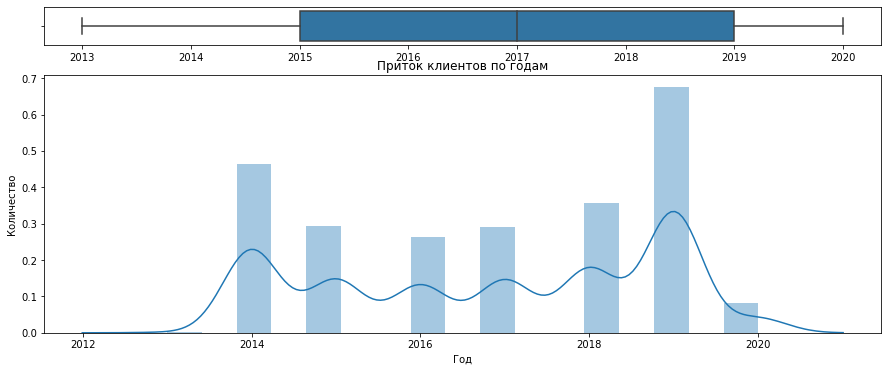

In [36]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=False, gridspec_kw={"height_ratios": (.9, 6)}, figsize=(15,6))
 
sns.boxplot(data['begin_date'].dt.year, ax=ax_box)
sns.distplot(data['begin_date'].dt.year, ax=ax_hist)
 
ax_box.set(xlabel=' ')
plt.title('Приток клиентов по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show();

<div style="border:solid gray 2px; padding: 20px">
    
Данные представлены периодом с конца 2013 года по начало 2020 года. Минимальное количество привлечённых клиентов приходится на 2016 год, наибольшее количество клиентов привлечено в 2019 году. C 2016 наблюдается непрерывный рост. </div>

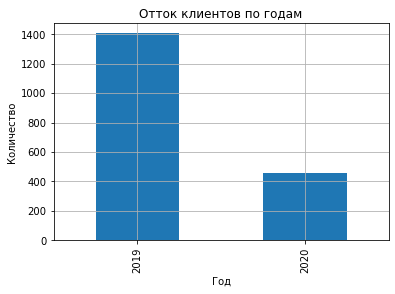

In [37]:
data.query('client_left == "Yes"')['end_date'].dt.year.value_counts().plot(kind ='bar', grid=True)
plt.title('Отток клиентов по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show;

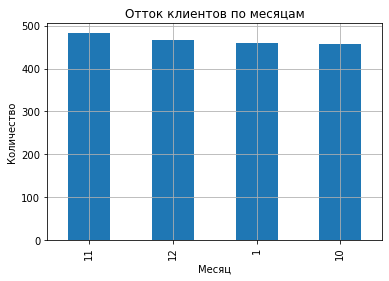

In [38]:
data.query('client_left == "Yes"')['end_date'].dt.month.value_counts().plot(kind ='bar', grid=True)
plt.title('Отток клиентов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Отток клиентов зафиксирован в октябре 2019 года и на протяжении последних четырех месяцев стабильно составляет немногим менее 500 клиентов. Либо фиксировать отток начали четыре месяца назад, либо в то время произошли изменения, повлекшие за собой такие последствия. </div>

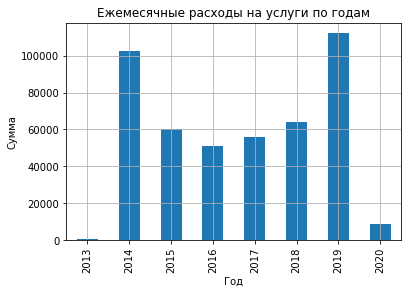

In [39]:
data.groupby(by=data['begin_date'].dt.year)['monthly_charges'].sum().plot(kind ='bar', grid=True)
plt.title('Ежемесячные расходы на услуги по годам')
plt.xlabel('Год')
plt.ylabel('Сумма')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
График соответствует графику притоку клиентов, что вполне закономерно. </div>

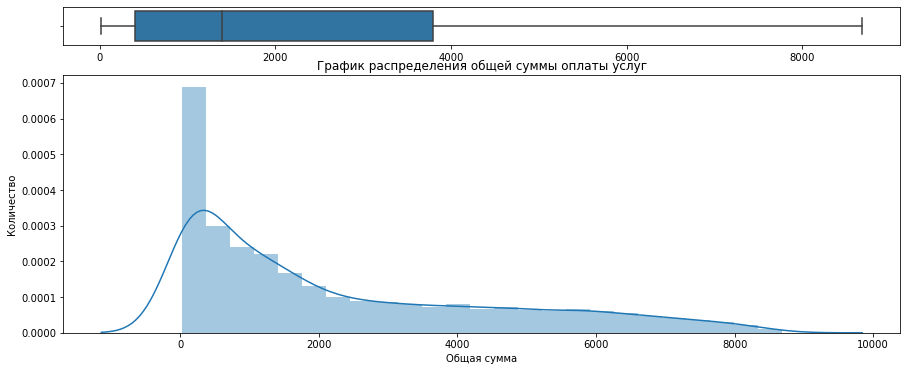

In [40]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=False, gridspec_kw={"height_ratios": (.9, 6)}, figsize=(15,6))
 
sns.boxplot(data['total_charges'], ax=ax_box)
sns.distplot(data['total_charges'], ax=ax_hist)
 
ax_box.set(xlabel=' ')
plt.title('График распределения общей суммы оплаты услуг')
plt.xlabel('Общая сумма')
plt.ylabel('Количество')
plt.show();

In [41]:
data['total_charges']

customerID
7590-VHVEG      29.85
5575-GNVDE    1889.50
3668-QPYBK     108.15
7795-CFOCW    1840.75
9237-HQITU     151.65
               ...   
6840-RESVB    1990.50
2234-XADUH    7362.90
4801-JZAZL     346.45
8361-LTMKD     306.60
3186-AJIEK    6844.50
Name: total_charges, Length: 7030, dtype: float64

<div style="border:solid gray 2px; padding: 20px">
    
Аномалий и выбросов в столбцах с числовыми значениями не выявлено, данные имеют положительное распределение. </div>

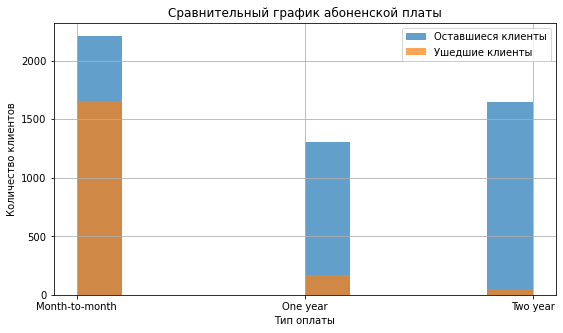

In [42]:
data.query('client_left == "No"')['type'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['type'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график абоненской платы')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
На графике видно, что наибольшее количество ушедших клиентов использовало ежемесячный тип оплаты. Реже всего уходят клиенты с оплатой на 2 года. </div>

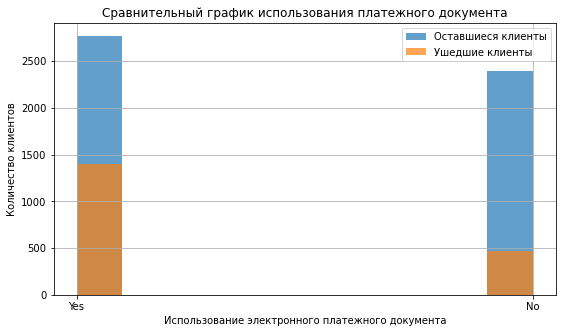

In [43]:
data.query('client_left == "No"')['paperless_billing'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['paperless_billing'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график использования платежного документа')
plt.xlabel('Использование электронного платежного документа')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Треть из тех кто пользовался электронной платежкой ушли, почти в 3 раза меньше ушедших среди тех, кто ими не пользовался. </div>

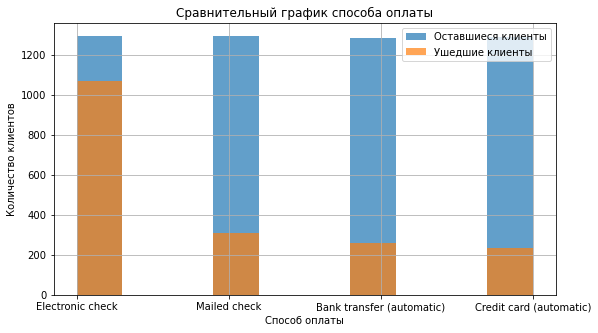

In [44]:
data.query('client_left == "No"')['payment_method'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['payment_method'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график способа оплаты')
plt.xlabel('Способ оплаты')
plt.ylabel('Количество клиентов')
plt.show;	

<div style="border:solid gray 2px; padding: 20px">
    
Наибольшая доля (почти 50%) ушедших использовала для оплаты электронный чек. Остальная половина почти одинаково использовала другие способы оплаты. </div>

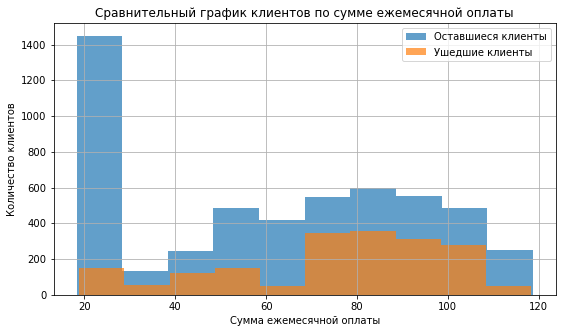

In [45]:
data.query('client_left == "No"')['monthly_charges'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['monthly_charges'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по сумме ежемесячной оплаты')
plt.xlabel('Сумма ежемесячной оплаты')
plt.ylabel('Количество клиентов')
plt.show;

In [46]:
print('Средняя оплата за телефон в месяц, уе:', round(data.query('internet_service == "No"')['monthly_charges'].mean()))
print('Количество клиентов использующие только телефон:', data.query('internet_service == "No"')['monthly_charges'].count())

Средняя оплата за телефон в месяц, уе: 21
Количество клиентов использующие только телефон: 1515


<div style="border:solid gray 2px; padding: 20px">
    
Распределение ушедших и оставшихся клиентов по сумме емесячной оплаты пропорционально. Вероятно что сумма не влияет на решение об уходе. Пик в районе обусловлен среднемесячной платой клиентов использующих только телефонные улуги, недовольных этим видом связи кратно меньше, чем остальными.</div>

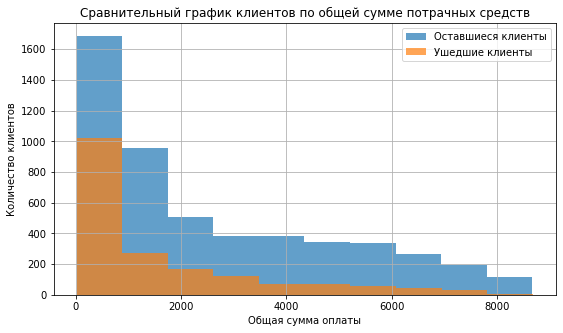

In [47]:
data.query('client_left == "No"')['total_charges'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['total_charges'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по общей сумме потрачных средств')
plt.xlabel('Общая сумма оплаты')
plt.ylabel('Количество клиентов')
plt.show;

Распределение по клиентов по общей сумме затрат на связь так же распределено пропорционально.

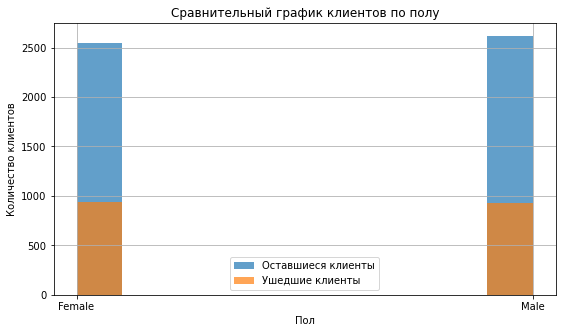

In [48]:
data.query('client_left == "No"')['gender'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['gender'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по полу')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Количество абонентов среди мужчин и женчин практически одинаково, как и количество обоих полов среди ушедших.</div>

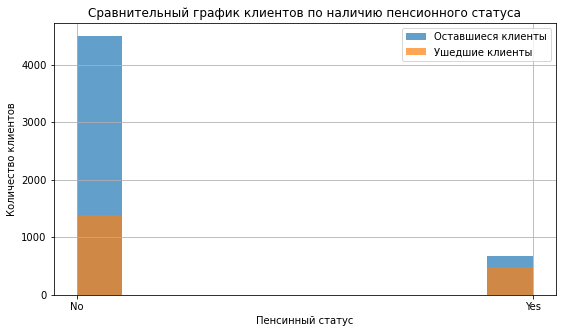

In [49]:
data.query('client_left == "No"')['senior_citizen'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['senior_citizen'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по наличию пенсионного статуса')
plt.xlabel('Пенсинный статус')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Количество ушедших и оставшихся абонентов среди пенсионеров почти одинаковое. </div>

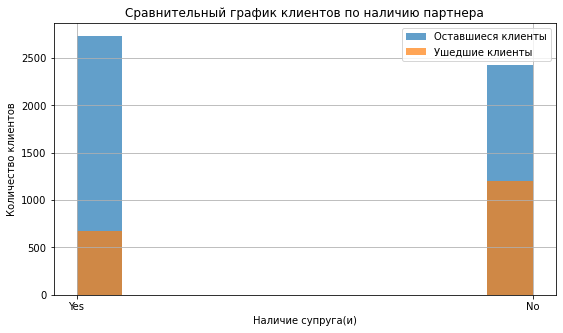

In [50]:
data.query('client_left == "No"')['partner'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['partner'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по наличию партнера')
plt.xlabel('Наличие супруга(и)')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Доля ушедших заметно больше у людей не имеющих супруга(и). </div>

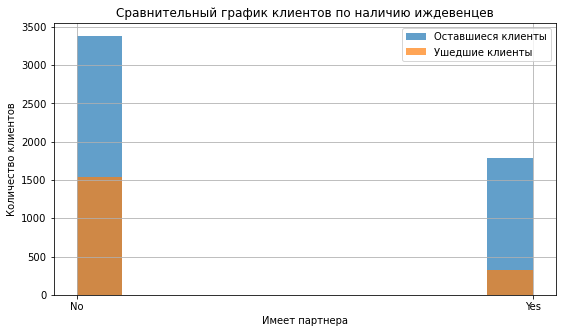

In [51]:
data.query('client_left == "No"')['dependents'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['dependents'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по наличию иждевенцев')
plt.xlabel('Имеет партнера')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Среди клиентов не имеющих иждевенцев доля ушедших больше. </div>

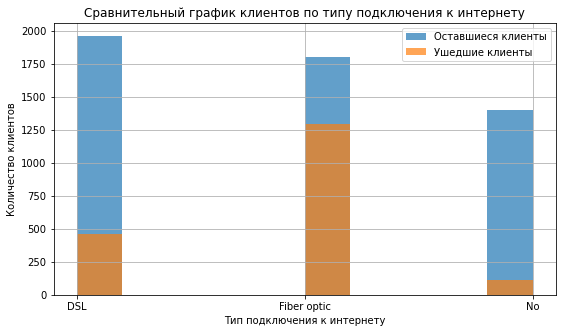

In [52]:
data.query('client_left == "No"')['internet_service'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['internet_service'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по типу подключения к интернету')
plt.xlabel('Тип подключения к интернету')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Две трети ушедших клиентов использовали для подключения к интернету оптиковолоконный кабель. Обращает на себя внимание, что среди неиспользовавших интернет меньше всего тех, кто ушёл (около 10%). </div>

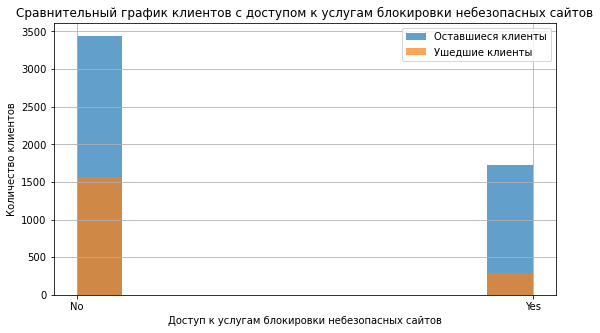

In [53]:
data.query('client_left == "No"')['online_security'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['online_security'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с доступом к услугам блокировки небезопасных сайтов')
plt.xlabel('Доступ к услугам блокировки небезопасных сайтов')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Доля ушедших клиентов, пользующихся услугами интернет безопасности значительно меньше. </div>

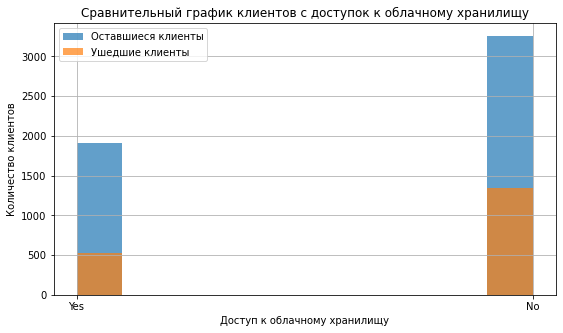

In [54]:
data.query('client_left == "No"')['online_backup'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['online_backup'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с доступок к облачному хранилищу')
plt.xlabel('Доступ к облачному хранилищу')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Доля ушедших клиентов, пользующихся услугами облачного хранилища также меньше, чем без него. </div>

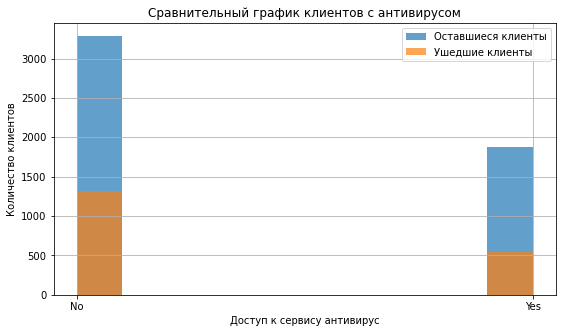

In [55]:
data.query('client_left == "No"')['device_protection'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['device_protection'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с антивирусом')
plt.xlabel('Доступ к сервису антивирус')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Доля ушедших клиентов, пользующихся услугами антивируса примерно одинакова. </div>

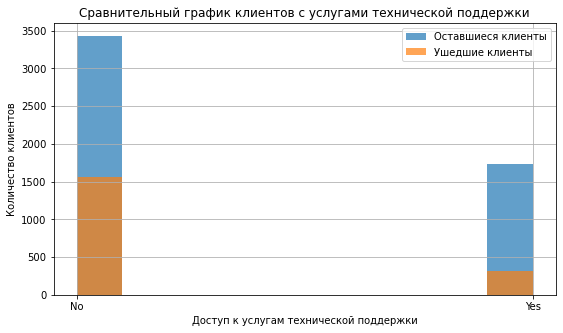

In [56]:
data.query('client_left == "No"')['tech_support'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['tech_support'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с услугами технической поддержки')
plt.xlabel('Доступ к услугам технической поддержки')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Среди тех, у кого есть возможность технической поддержки процент ушедших в 2 раза меньше. </div>

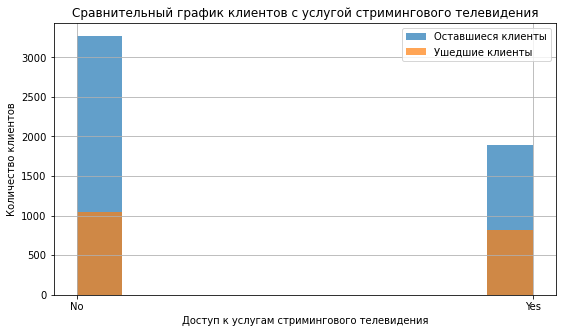

In [57]:
data.query('client_left == "No"')['streaming_tv'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['streaming_tv'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с услугой стримингового телевидения')
plt.xlabel('Доступ к услугам стримингового телевидения')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Среди тех, у кого есть нет стримингового тв меньше ушедших. </div>

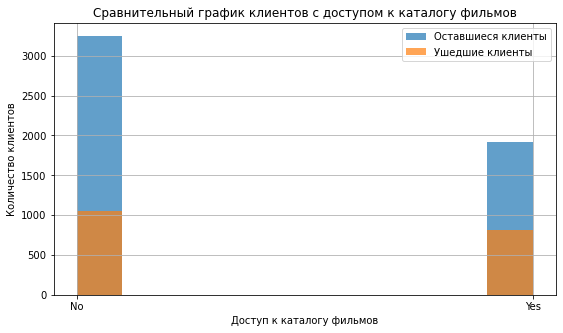

In [58]:
data.query('client_left == "No"')['streaming_movies'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['streaming_movies'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с доступом к каталогу фильмов')
plt.xlabel('Доступ к каталогу фильмов')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Среди тех, у кого есть нет доступа к каталогу  фильмов меньше ушедших. Фильмы не не останавливают от ухода </div>

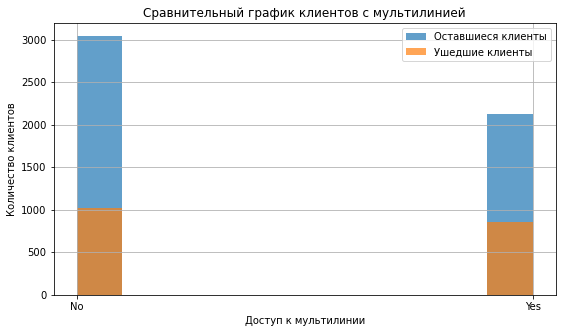

In [59]:
data.query('client_left == "No"')['multiple_lines'].hist(alpha=0.7, legend=True, figsize=(9, 5))
data.query('client_left == "Yes"')['multiple_lines'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с мультилинией')
plt.xlabel('Доступ к мультилинии')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Доля ушедших не сильно отличается. </div>

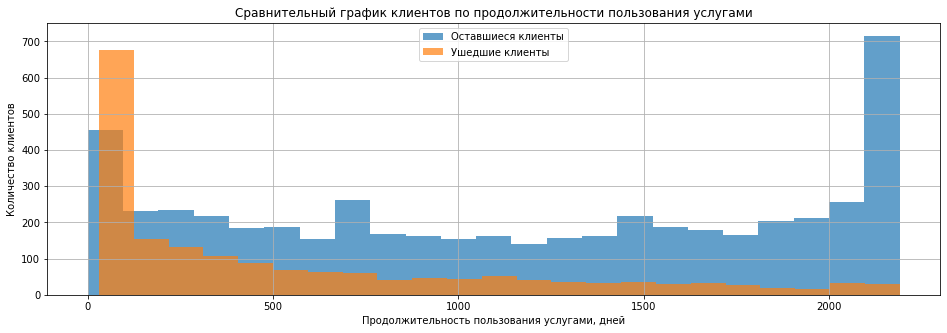

In [60]:
data.query('client_left == "No"')['duration'].hist(alpha=0.7, legend=True, figsize=(16, 5), bins=23)
data.query('client_left == "Yes"')['duration'].hist(alpha=0.7, legend=True, figsize=(16, 5), bins=23)
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по продолжительности пользования услугами')
plt.xlabel('Продолжительность пользования услугами, дней')
plt.ylabel('Количество клиентов')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Чем дольше клиент пользуется услугами компании, тем меньше вероятность его ухода. </div>

In [61]:
data['year'] = pd.DatetimeIndex(data['begin_date']).year
data['month'] = pd.DatetimeIndex(data['begin_date']).month

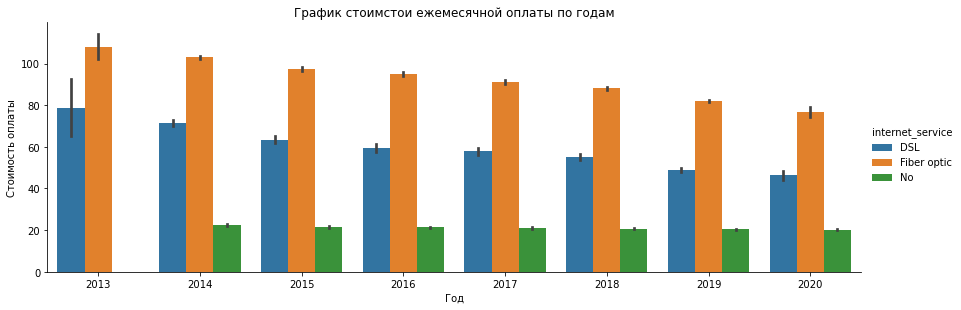

In [62]:
sns.catplot(x='year', y='monthly_charges', hue='internet_service', data=data, kind='bar', height=4, aspect=3)
plt.title('График стоимстои ежемесячной оплаты по годам')
plt.xlabel('Год')
plt.ylabel('Стоимость оплаты')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
Наблюдаем ежегодное снижение помесячных оплат услуг. </div>

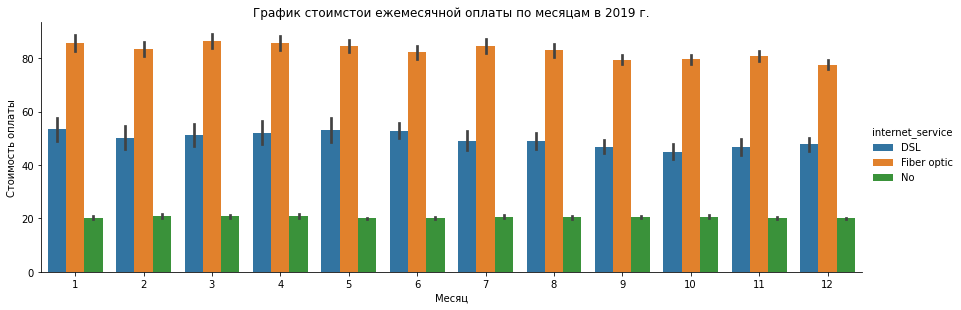

In [63]:
sns.catplot(x='month', y='monthly_charges', hue='internet_service', data=data.query('year == 2019'), 
            kind='bar', height=4, aspect=3)
plt.title('График стоимстои ежемесячной оплаты по месяцам в 2019 г.')
plt.xlabel('Месяц')
plt.ylabel('Стоимость оплаты')
plt.show;

<div style="border:solid gray 2px; padding: 20px">
    
В последнем (полном) 2019 году помесячная стоимость услуг для телефонии была неизменна, а стоимость интернет услуг немного снижалась. Резких изменений стоимости нет, как нет и повышений, вероятнее всего стоимость услуг не оказывает значительного влияния на отток.</div>

In [64]:
data = data.drop(columns=['year', 'month'], axis=1)

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid gray 2px; padding: 20px">
<b>Общий вывод:</b>
    
В результате проведенного анализа определился инфопортрет ушедшего от оператора связи клиента: 
    
Клиент среднего возраста, в большей мере без супругов и детей, активно пользующийся интернетом, оплачивающий услуги связи электронным чеком по электронному платежному документу в течении первых нескольких месяцев через интернет подключенный по оптиковолоконной линии, не имеющий услуги блокировки небезопасных сайтов, облачного хранилища и антивируса, без возможности помощи тех.поддержки, склонный к просмотру тв и фильмов через интернет

Возможно это указывает на технические проблемы с оптиковолоконным подключенем со стороны оператора, которые клиенты не способны решить самостоятельно или недавно появился конкурирующий оператор.
</div>

## Проверка мультиколлинеарности

### Коэффициент корреляции

In [65]:
interval_cols = ['monthly_charges', 'total_charges', 'duration']
phik_overview = data.phik_matrix(interval_cols=interval_cols)

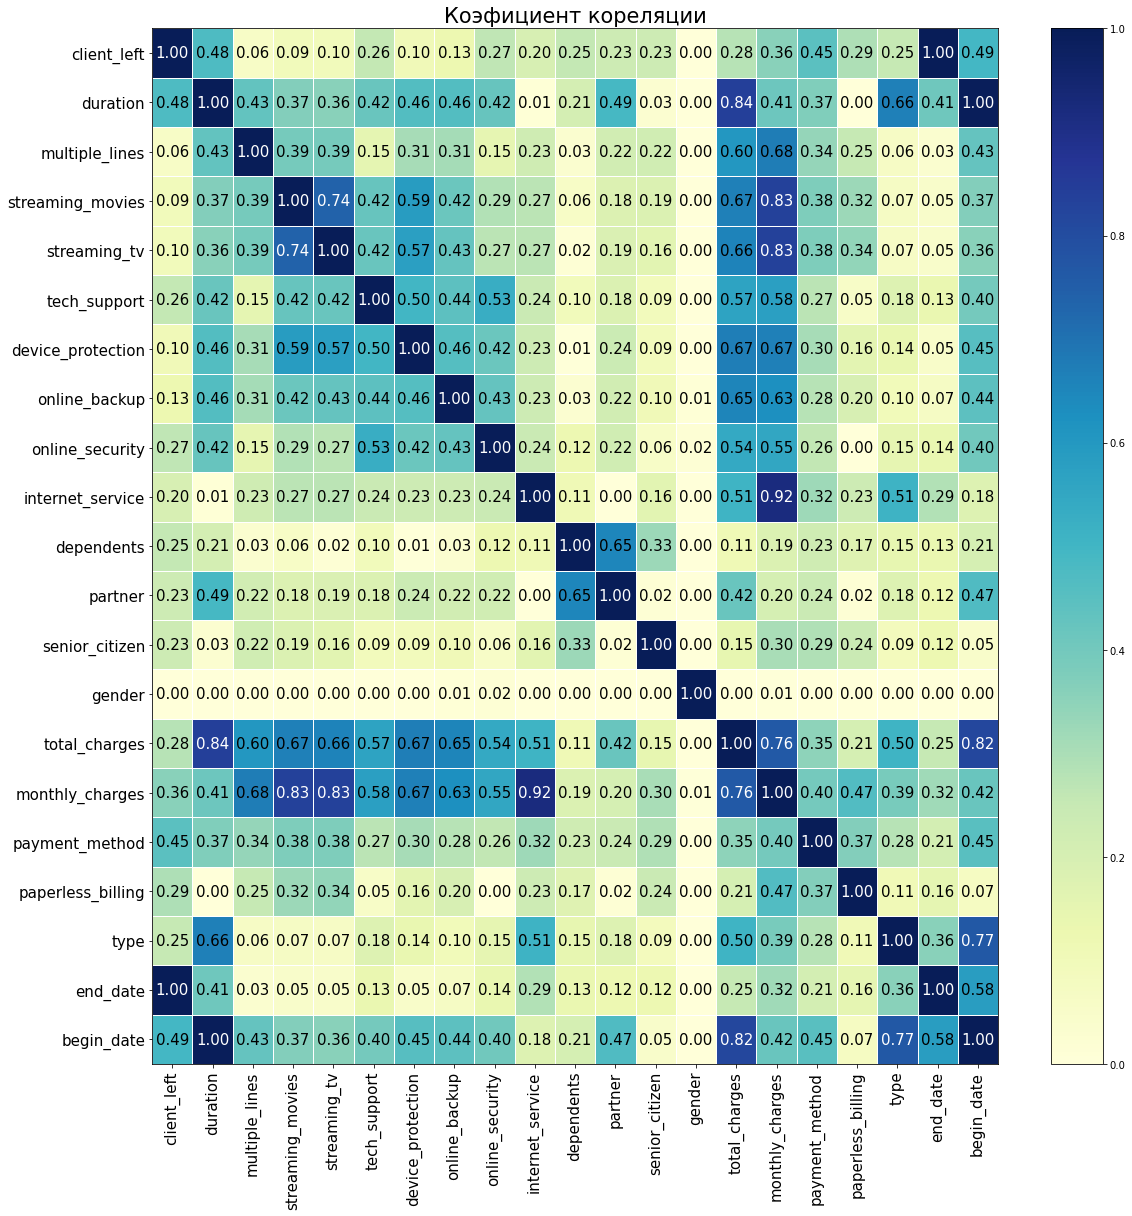

In [66]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='YlGnBu', 
                        title='Коэфициент кореляции', 
                        fontsize_factor=1.5, 
                        figsize=(17, 17))
plt.tight_layout()

<div style="border:solid gray 2px; padding: 20px">
    
Наблюдается **весьма высокий** коэффициент корреляции между такими переменными, как:
    
- `internet_service - monthly_charges`
    
**высокий:** 
    
- `duration - total_charges`
- `total_charges - monthly_charges`
- `total_charges - begin_date`    
- `streaming_movies - streaming_tv`
- `streaming_movies - monthly_charges`
- `streaming_tv - monthly_charges`
- `type - begin_date`    
    
Нужно проверить насколько статистически значимыми являются коэффициенты.
</div>

### Коэффициент статистической значимости 

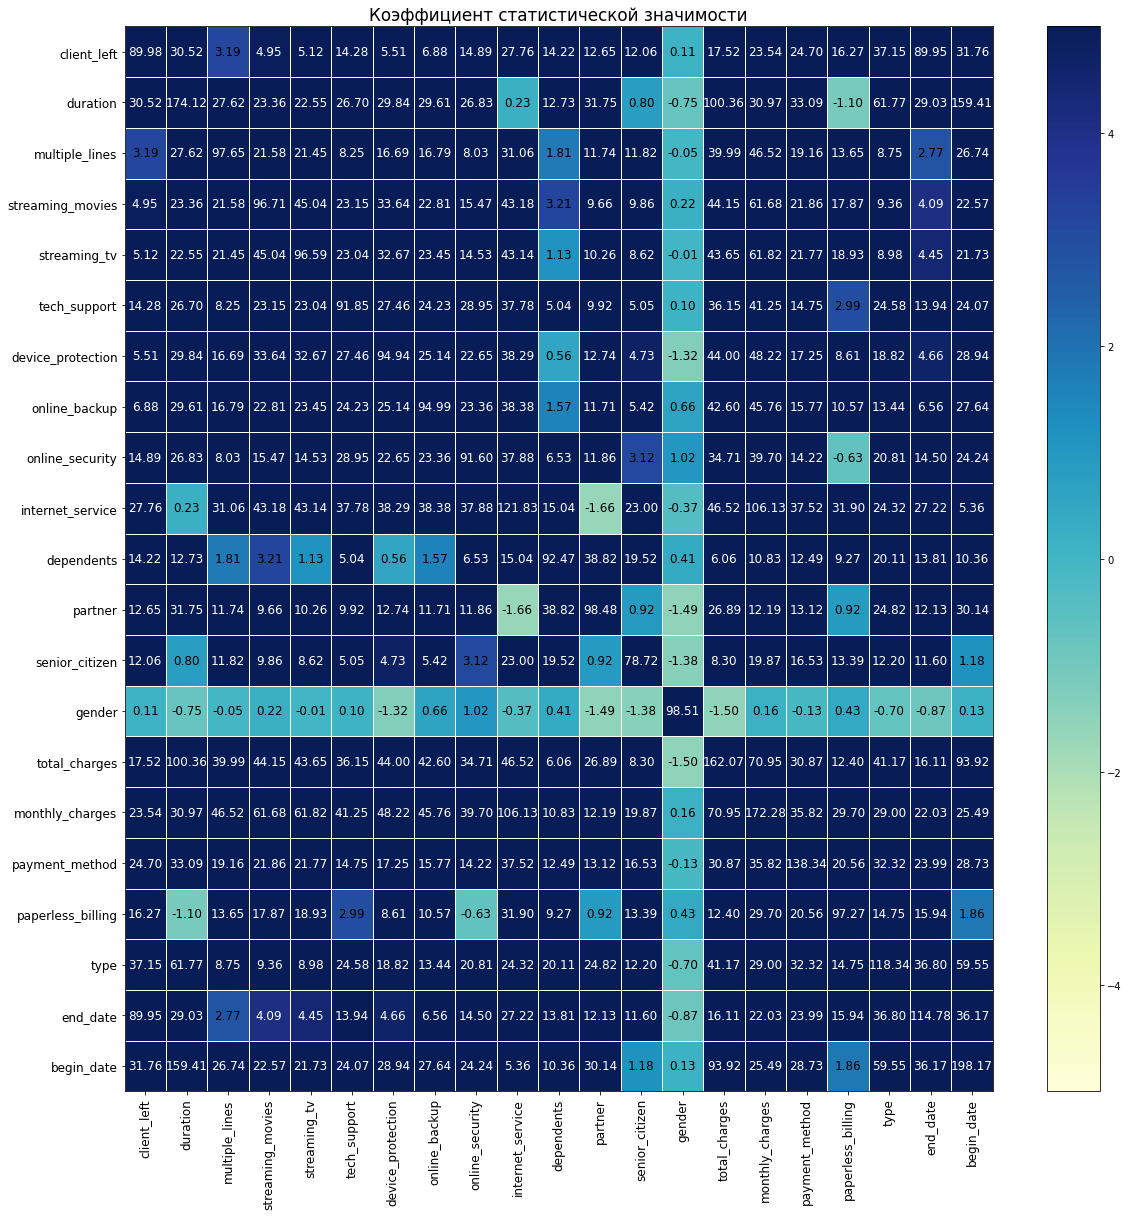

In [67]:
significance_overview = data.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title='Коэффициент статистической значимости', 
                        usetex=False, color_map='YlGnBu', fontsize_factor=1.2, figsize=(17, 17))
plt.tight_layout()

<div style="border:solid gray 2px; padding: 20px">
    
Можем видеть на графике, что признак `gender` не оказывает никакого влияния на другие признаки, его коэффициенты  не превышают порога p-значения. 
    
Наиболее высокие коэффициенты у:
- `internet_service`,
- `total_charges`, 
- `monthly_charges`, 
- `duration`,
- `begin_date`
    
Признаков много, нужно понять как в общем коррелирует отдельный признак со всеми, для этого необходимо найти глобальный коэффициент корреляции для каждого признака.
</div>

### Глобальный коэффициент корреляции

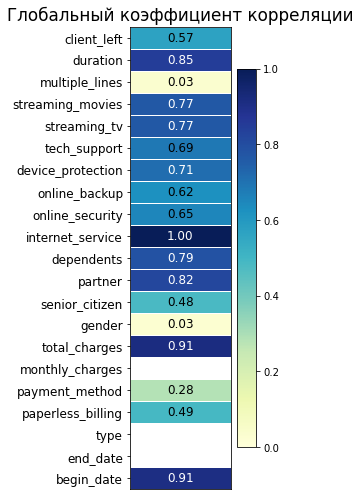

In [68]:
global_correlation, global_labels = data.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(4, 7),
                        color_map='YlGnBu', title='Глобальный коэффициент корреляции',
                        fontsize_factor=1.2)
plt.tight_layout()

<div style="border:solid gray 2px; padding: 20px">
    
Это дает нам представление о том, насколько хорошо один признак может быть смоделирован с использованием других признаков
    
Некоторые признаки имеют довольно высокие значения глобальной корреляционной метрики, причем самое высокое значение у `internet_servicе` и очень высокие у `total_changes`, `begin_date` и `duration`, а такие как `monthly_charges`, `type`, `end_date` наоборот очень низкие. Далее изучим взаимную значимость признаков `internet_servicе`, `duration`, `monthly_charges` и  `total_changes`
</div>

### Значимость признаков

In [69]:
def plot_corr_matrix(var_1, var_2, var_3=None):
    """Строит график-матрицу признаков"""
    if (var_1 in interval_cols and var_2 not in interval_cols) or (var_2 in interval_cols and var_1 not in interval_cols):
 
        tmp_interval_cols = [var_3]

        outlier_signifs, binning_dict = data[[var_1, var_2]].outlier_significance_matrix(interval_cols=tmp_interval_cols, 
                                                                                  retbins=True)

        zvalues = outlier_signifs.values
        xlabels = outlier_signifs.columns
        ylabels = outlier_signifs.index

        plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                                x_label=var_2,y_label=var_1,
                                vmin=-5, vmax=5, title='Взаимная корреляция',
                                identity_layout=False, fontsize_factor=1.2, 
                                color_map='YlGnBu', figsize=(7, 6))
    else:
        outlier_signifs, binning_dict = data[[var_1,var_2]].outlier_significance_matrix(retbins=True)

        zvalues = outlier_signifs.values
        xlabels = binning_dict[var_2] if var_2 in binning_dict.keys() else outlier_signifs.columns
        ylabels = binning_dict[var_1] if var_1 in binning_dict.keys() else outlier_signifs.index

        plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                                x_label=var_2,y_label=var_1,
                                vmin=-5, vmax=5, title='Взаимная корреляция',
                                identity_layout=False, fontsize_factor=1.2, 
                                color_map='YlGnBu', figsize=(10, 10))

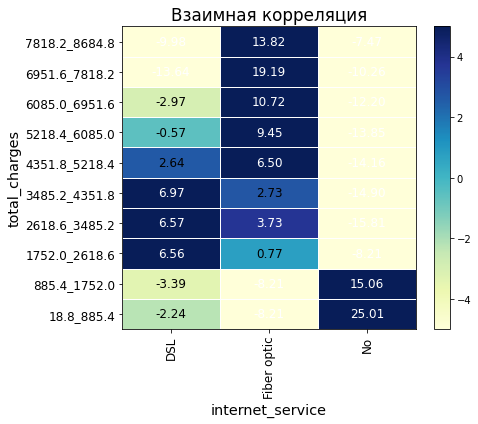

In [70]:
plot_corr_matrix('total_charges', 'internet_service', 'total_charges')

interval columns not set, guessing: ['total_charges', 'monthly_charges']


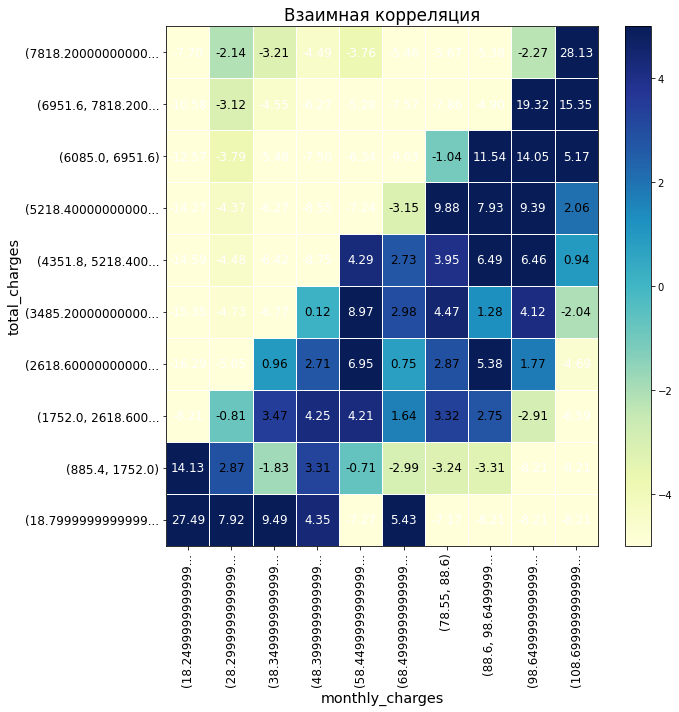

In [71]:
plot_corr_matrix('total_charges', 'monthly_charges', 'total_charges')

interval columns not set, guessing: ['total_charges', 'duration']


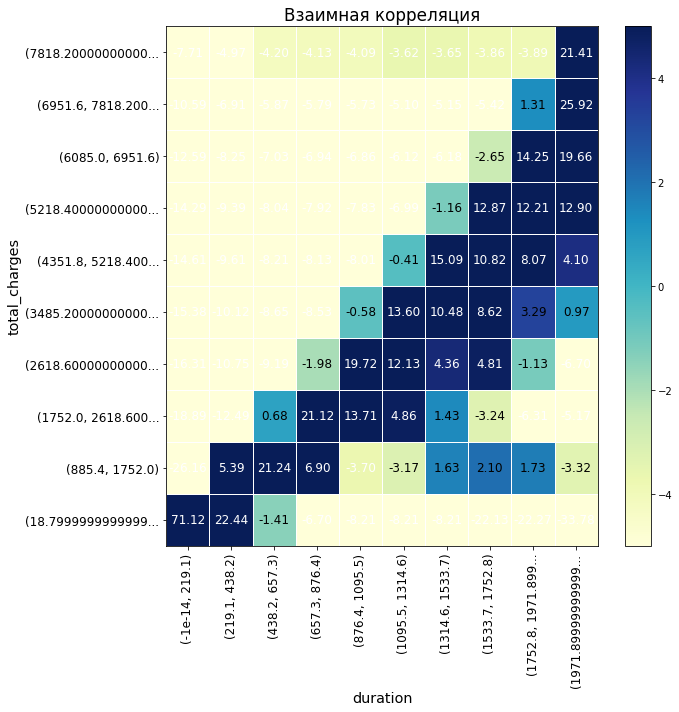

In [72]:
plot_corr_matrix('total_charges', 'duration', 'duration')

interval columns not set, guessing: ['duration', 'monthly_charges']


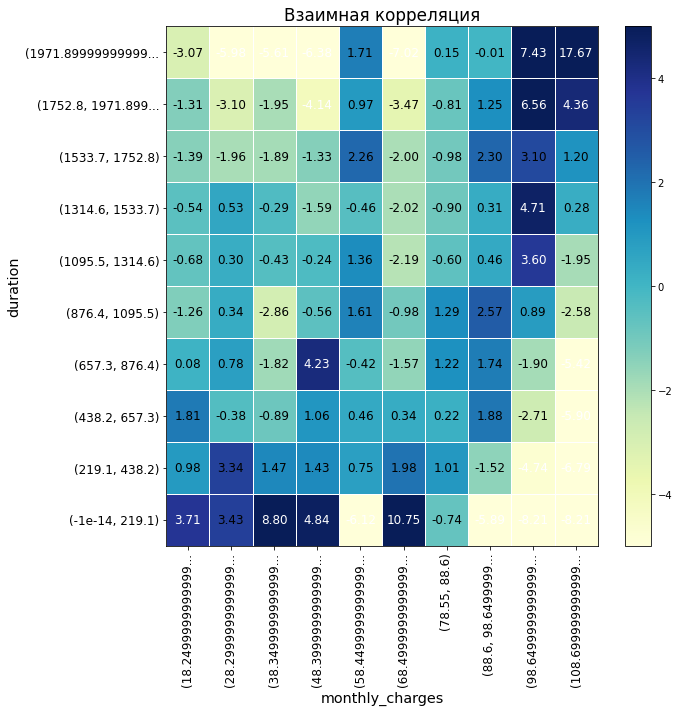

In [73]:
plot_corr_matrix('duration', 'monthly_charges', 'duration')

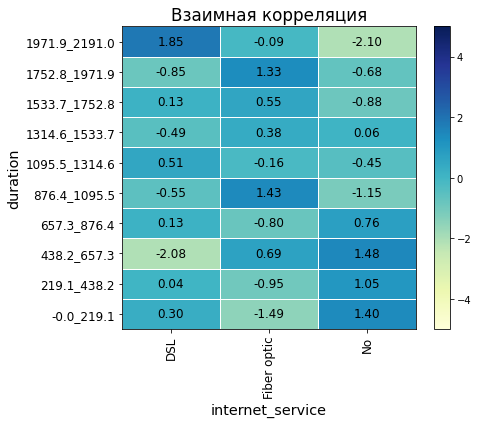

In [74]:
plot_corr_matrix('duration', 'internet_service', 'duration')

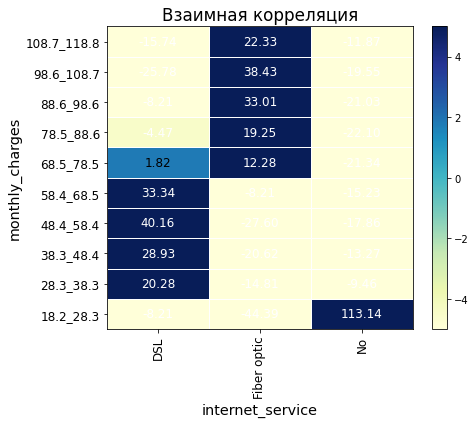

In [75]:
plot_corr_matrix('monthly_charges', 'internet_service', 'monthly_charges')

<div style="border:solid gray 2px; padding: 20px">

Видим высокую коллинеарность признаков `total_charges` и `monthly_charges`:
    
- `total_charges` - `internet_service`
- `total_charges` - `duration`
- `total_charges` - `monthly_charges`   
_____________________________________   
- `monthly_charges` - `total_charges`
- `monthly_charges` - `internet_service`
    
</div>

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid gray 2px; padding: 20px">
<b>Вывод:</b>
    
В ходе проверки на мультиколлинеарность изучили коэффициенты корреляции признаков, их статистическую значимость и посчитали глобальный коэффициент корреляция для каждого из признаков.
    
В результате выяснилось, что признак `gender` не является статистически значимым и не влияет на другие признаки. Признаки `duration` и `client_left` зависимы от признаков `begin_date` и `end_date` соответственно. Так же имеется группа признаков `total_charges` и `monthly_charges` с высокой мультиколлинеарностью, однако если их удалить, то останется всего один сильный признак и модель будет линейно зависима только от него. 
    
Принято решение не использовать признаки `gender`, `begin_date`, `end_date` для обучения модели, признаки `total_charges` и `monthly_charges` оставить.
</div>

## Признаки для модели

### Проверка баланса целевого признака

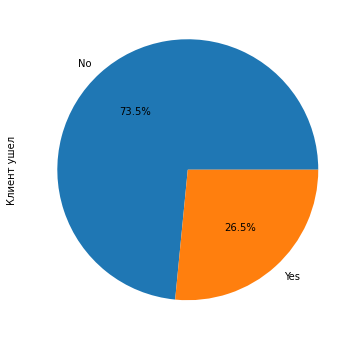

In [76]:
data['client_left'].value_counts(normalize=True).plot(kind='pie', label = 'Клиент ушел', autopct='%1.1f%%', figsize=(6, 6))
plt.show()

<div style="border:solid gray 2px; padding: 20px">
    
Наблюдаем дисбаланс. </div>

### Классификация данных

In [77]:
num_cols = ['duration', 'total_charges', 'monthly_charges']
cat_cols = ['paperless_billing', 'payment_method', 'senior_citizen',
            'partner', 'dependents', 'internet_service', 'online_security',
            'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
            'streaming_movies', 'multiple_lines', 'type']
targ_cols = ['client_left']
del_cols = ['begin_date', 'end_date', 'gender']

### Получение признаков

In [78]:
features = data[num_cols+cat_cols]
target = pd.get_dummies(data[targ_cols], drop_first=True)

print('Размер данных признаков:', features.shape, ', Размер данных целевого признака:', target.shape)

Размер данных признаков: (7030, 17) , Размер данных целевого признака: (7030, 1)


### Создание выборок

In [79]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25, random_state=RANDOM_STATE, 
                                                                            stratify=target)

In [80]:
print('   train', '  |', '  test')
print('----------------------')
print(features_train.shape, '|', features_test.shape)
print(target_train.shape, ' |', target_test.shape)

   train   |   test
----------------------
(5272, 17) | (1758, 17)
(5272, 1)  | (1758, 1)


### Определение моделей и гиперпараметров

In [81]:
cbc = CatBoostClassifier(random_state=RANDOM_STATE)
sgd = SGDClassifier(random_state=RANDOM_STATE)
lgbm = lgb.LGBMClassifier(random_state=RANDOM_STATE)


grid_params_sgd = {'alpha': [0.0001, 0.008, 0.1],
                   'max_iter': [3, 10, 100],
                   'loss' : ['hinge', 'modified_huber', 'log'],
                   'penalty' : ['l1', 'l2', 'elasticnet'],
                   'class_weight' : ['balanced', None]}

grid_params_cat = {'verbose': [False],
                   'depth' : [2, 5, 10],                               # глубина дерева
                   'learning_rate' : [0.01, 0.1],                      # шаг обучения
                   'iterations' : [500, 1000]}                         # количество деревьев
                   
    
grid_params_lgbm = {'verbose': [-1],
                    'boosting_type' : ['gbdt'],                        # алгоритм
                    'objective' : ['binary'],                          # целевая функция
                    'num_leaves' : [11, 21, 31,],                      # количество листьев
                    'max_depth': [2, 5, 10],                           # глубина дерева
                    'num_iterations': [ 500, 1000],                    # количество деревьев
                    'learning_rate': [0.01, 0.1],                      # шаг обучения
                    'num_threads' : [1]}
                    

scorers = {'accuracy':'accuracy', 'roc_auc':'roc_auc'}

In [82]:
grid_sgd = GridSearchCV(estimator=sgd,
                        param_grid=grid_params_sgd,
                        scoring=scorers,
                        refit='roc_auc',
                        return_train_score=True,
                        cv=3,
                        n_jobs=-1) 

In [83]:
grid_cat = GridSearchCV(estimator=cbc,
                        param_grid=grid_params_cat,
                        scoring=scorers,
                        refit='roc_auc',
                        return_train_score=True,
                        cv=3,
                        n_jobs=-1) 


In [84]:
grid_lgbm = GridSearchCV(estimator=lgbm,
                        param_grid=grid_params_lgbm,
                        scoring=scorers,
                        refit='roc_auc',
                        return_train_score=True,
                        cv=3) 

### Кодирование признаков для SGDClassifier

In [85]:
# масштабируем числовые значения
num_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())              
])

# кодируем категориальные значения
cat_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='error', sparse=False, drop='first'))  # кодируем категориальные значения
])

# cобираем данные 
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
    ],
    remainder='drop',                         # игнорируем другие столбцы (target)
    n_jobs=-1)                                # используем все процессоры для параллельной работы


sgdc = Pipeline(steps=[
    ('col_trans', col_trans),
    ('grid_cv', grid_sgd)
])

### Обучение моделей

**SGDClassifier**

In [86]:
%%time
sgdc.fit(features_train, target_train)

CPU times: total: 1.69 s
Wall time: 7.85 s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_charges',
                                                   'monthly_charges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'inte...
                                                   'type'])])),
                ('grid_cv',
                 GridSearchCV(cv=3,
                              estimator=SGDClassifier(random_state=270323),
                              n_jobs=-1,
                              param_grid={'alpha': [0.0001, 0.008, 0.1],
                                          'class_weight': ['balanced', None],
                                          'loss': ['hinge', 'modified_huber',
                                                   'log'],
                                          'max_iter': [3, 10, 100],
                                          'penalty': ['l1', 'l2',
                                                      'elasticnet']},
                              refit='roc_auc', return_train_score=True,
                              scoring={'accuracy': 'accuracy',
                                       'roc_auc': 'roc_auc'}))])

In [87]:
grid_sgd.best_params_

{'alpha': 0.008,
 'class_weight': 'balanced',
 'loss': 'modified_huber',
 'max_iter': 100,
 'penalty': 'l2'}

In [88]:
grid_sgd.best_score_

0.840874205914166

In [89]:
res_sgd = ['SGDClassifier', 
           round(grid_sgd.cv_results_['mean_test_roc_auc'].max(), 3), 
           round(grid_sgd.cv_results_['mean_test_accuracy'].max(), 3)]

print(f'Лучший результат метрики AUC-ROC: {res_sgd[1]}')
print(f'Лучший результат метрики Accuracy: {res_sgd[2]}')

Лучший результат метрики AUC-ROC: 0.841
Лучший результат метрики Accuracy: 0.803


**CatBoostClassifier**

In [90]:
%%time
grid_cat.fit(features_train, target_train, cat_features=cat_cols)

CPU times: total: 1min 5s
Wall time: 11min 36s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001A9B052B250>,
             n_jobs=-1,
             param_grid={'depth': [2, 5, 10], 'iterations': [500, 1000],
                         'learning_rate': [0.01, 0.1], 'verbose': [False]},
             refit='roc_auc', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'})

In [91]:
grid_cat.best_params_

{'depth': 5, 'iterations': 1000, 'learning_rate': 0.1, 'verbose': False}

In [92]:
grid_cat.best_score_

0.9010831068321782

In [93]:
res_cat = ['CatBoostClassifier', 
           round(grid_cat.cv_results_['mean_test_roc_auc'].max(), 3), 
           round(grid_cat.cv_results_['mean_test_accuracy'].max(), 3)]

print(f'Лучший результат метрики AUC-ROC: {res_cat[1]}')
print(f'Лучший результат метрики Accuracy: {res_cat[2]}')

Лучший результат метрики AUC-ROC: 0.901
Лучший результат метрики Accuracy: 0.858


**LGBMClassifier**

In [94]:
features_train_lgbm = features_train.copy()

for col in [cat_cols]:
    features_train_lgbm[col] = features_train_lgbm[col].astype('category')

In [95]:
%%time
grid_lgbm.fit(features_train_lgbm, target_train, categorical_feature=cat_cols)

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM]

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM]

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=270323),
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.01, 0.1], 'max_depth': [2, 5, 10],
                         'num_iterations': [500, 1000],
                         'num_leaves': [11, 21, 31], 'num_threads': [1],
                         'objective': ['binary'], 'verbose': [-1]},
             refit='roc_auc', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'})

In [96]:
grid_lgbm.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 2,
 'num_iterations': 1000,
 'num_leaves': 11,
 'num_threads': 1,
 'objective': 'binary',
 'verbose': -1}

In [97]:
grid_lgbm.best_score_

0.8966290136088579

In [98]:
res_lgbm = ['LGBMClassifier', 
            round(grid_lgbm.cv_results_['mean_test_roc_auc'].max(), 3), 
            round(grid_lgbm.cv_results_['mean_test_accuracy'].max(), 3)]

print(f'Лучший результат метрики AUC-ROC: {res_lgbm[1]}')
print(f'Лучший результат метрики Accuracy: {res_lgbm[2]}')

Лучший результат метрики AUC-ROC: 0.897
Лучший результат метрики Accuracy: 0.851


In [99]:
leaderboard = pd.DataFrame(data = [res_sgd, res_cat, res_lgbm], columns =['Модель', 'AUC-ROC', 'Accuracy'])
leaderboard

,Модель,AUC-ROC,Accuracy
0,SGDClassifier,0.841,0.803
1,CatBoostClassifier,0.901,0.858
2,LGBMClassifier,0.897,0.851


<div style="border:solid gray 2px; padding: 20px">
    
Отфильтрованы признаки, созданы выборки, определены гиперпараметры, собран пайплайн. Для обучения выбраны модели, одна с градиентным спуском SGDClassifier и две бустинговые модели с деревьями решений LGBMClassifier и CatBoostClassifier с разных континентов, своеобразное соперничество Google против Yandex. Модель CatBoostClassifier показала лучший результат метрики ROC-AUC. Будем проверять эту модель на тестовой выборке. Дисалансом заниматься не будем, так как он на AUC-ROC не влияет. Поехали!
</div>

In [100]:
print(f'Тестовый результат метрики AUC-ROC: {round(grid_cat.score(features_test, target_test), 2)}')
print(f'Тестовый результат метрики Accuracy:', round(grid_cat.cv_results_['mean_test_accuracy'].max(), 2))

Тестовый результат метрики AUC-ROC: 0.93
Тестовый результат метрики Accuracy: 0.86


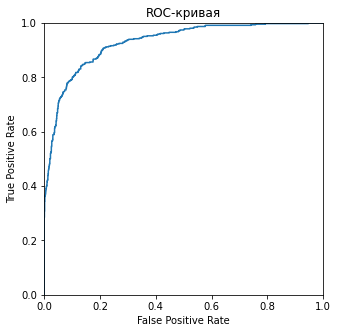

In [101]:
fpr, tpr, thresholds = roc_curve(target_test, grid_cat.predict_proba(features_test)[:, 1]) # функция для построения ROC-кривой

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr)                          # ROC-кривая для модели
plt.ylim([0.0, 1.0])                        # границы осей от 0 до 1
plt.xlim([0.0, 1.0])                        # границы осей от 0 до 1
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') 
plt.show()

### Важность признаков

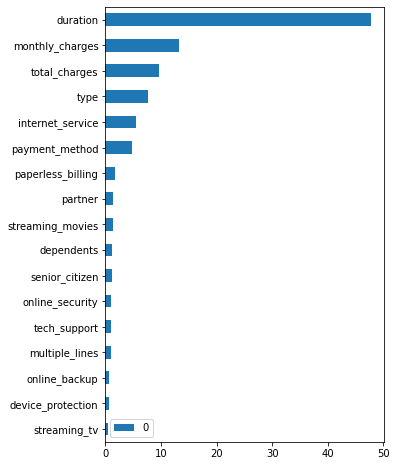

In [102]:
def feature_important(grid_model, features_train):
    temp = pd.DataFrame(data = grid_model.best_estimator_.feature_importances_).T
    temp.columns = features_train.columns
    temp.T.sort_values(by=0, ascending=True).plot(kind='barh', figsize=(5,8))
    
feature_important(grid_cat, features_train)

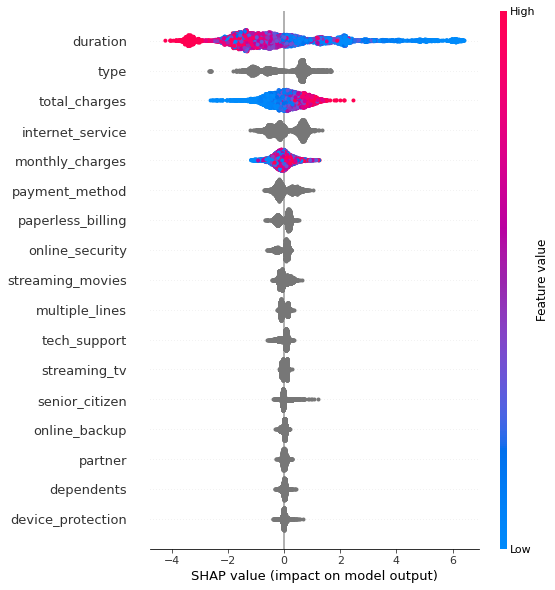

In [103]:
explainer = shap.TreeExplainer(grid_cat.best_estimator_)
shap_values = explainer.shap_values(Pool(features_train, target_train, cat_features = cat_cols))
shap.summary_plot(shap_values, features_train)

<div style="border:solid gray 2px; padding: 20px">
    
Читаем график:
- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точки на графике, тем выше значения фичи в ней

</div>

### Матрица ошибок

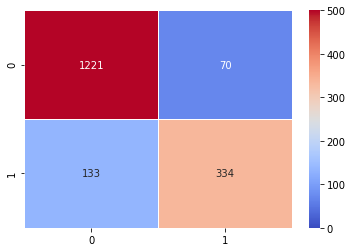

In [104]:
cnf_matrix = confusion_matrix(target_test, grid_cat.predict(features_test))
sns.heatmap(cnf_matrix, annot=True, fmt=".0f", linewidth=.5, cmap= 'coolwarm', vmin = 0, vmax = 500)
plt.show();

<div style="border:solid gray 2px; padding: 20px">
    
<b>Вывод:</b> 
    
На бустинговых модлях удалось получить требуемую метрику. Тестирование подтвердило правильность работы модели. Несбалансированность целевого признака не оказала негативного вляиния на предсказания. Для лучшей модели самым важным признаком оказался `duration`(продолжительность контракта), неожиданности тут не произошло, это мы наблюдали в ходе анализа данных, так как основной отток наблюдался в последние несколько месяцев. Верным решением было не удалять признаки `total_charges` и `monthly_charges`так они одни их немногих признаков, влияющих на ход решения. Так же имеются признаки, которые вообще не оказывают никакого вляния на решение клиента уйти или остаться, это как раз те специальные условия, которые будут предлагаться клиенту, что бы его удержать. 
</div>

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid gray 2px; padding: 20px">
<b><font size=5> Отчет о проделанной работе </font></b>

   
**В ходе работы были выполнены следющие операции:**
  1. Загружены и изучены данные;
  2. Выполнена предобработка данных;
  3. Проведён исследовательский анализ данных;
  4. Проведена проверка данных на коллинеарность;
  5. Сформированы признаки (лишнее удалено, недостающее добавлено);
  6. Проведена кодировка, масштабирование признаков для некоторых моделей;
  7. Подготовлены тренировочная и тестовая выборки;
  8. Выбрано несколько моделей, определены их лучшие гиперпаметры, модели обучены, протестировано предсказание лучшей модели;
  
**Ключевые шаги в решении задачи**
  1. Анализ данных и подготовка признаков;
  2. Настройка моделей.
  
**Признаки для обучения модели и их предобработка**
  1. Для обучения модели использовались исходные признаки за исключением `gender`, `begin_date`, `end_date` и один дополнительно сгенерированный признак `duration` - срок действия контракта в днях;
  2. Данные всех признаков приведены к требуемому типу, отсутсвующие значения заполнены, дубликаты удалены.
  
**Итоговая модель, её гиперпараметы и качество**
  1. Итоговая модель CatBoostClassifier со следующими параметрами:
     - `random_state = 270323`
     - `depth = 5`, 
     - `iterations = 1000`, 
     - `learning_rate = 0.1`
  2. Тестовый результат метрики AUC-ROC: 0.93 
  3. Тестовый результат метрики Accuracy: 0.86
    
</div>